In [1]:
!pip install -U vnstock3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 kB 1.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np

In [3]:
from vnstock3 import Vnstock
stock = Vnstock().stock(symbol='ACB', source='TCBS')


    Khi tiếp tục sử dụng Vnstock3, bạn xác nhận rằng bạn đã đọc, hiểu và đồng ý với Chính sách quyền riêng tư và Điều khoản, điều kiện về giấy phép sử dụng Vnstock3.

    Chi tiết:

    - Giấy phép sử dụng phần mềm: https://vnstocks.com/docs/tai-lieu/giay-phep-su-dung
    - Chính sách quyền riêng tư: https://vnstocks.com/docs/tai-lieu/chinh-sach-quyen-rieng-tu
    


In [4]:
df = stock.quote.history(start='2020-01-01', end='2024-08-21', interval='1D')
df

,time,open,high,low,close,volume
0,2020-08-17,8.74,8.91,8.70,8.91,6222301
1,2020-08-18,8.98,9.02,8.84,8.84,4710796
2,2020-08-19,8.88,8.91,8.77,8.84,9263369
3,2020-08-20,9.25,9.52,8.98,9.34,19475136
4,2020-08-21,9.34,9.52,9.25,9.52,7392791
...,...,...,...,...,...,...
1238,2024-08-15,23.55,23.60,23.45,23.50,2660430
1239,2024-08-16,23.50,24.00,23.50,24.00,6524010
1240,2024-08-19,24.00,24.15,23.95,24.05,3843540
1241,2024-08-20,24.05,24.30,24.00,24.10,5422431


In [5]:
HOSE_list = stock.listing.symbols_by_group('HOSE')

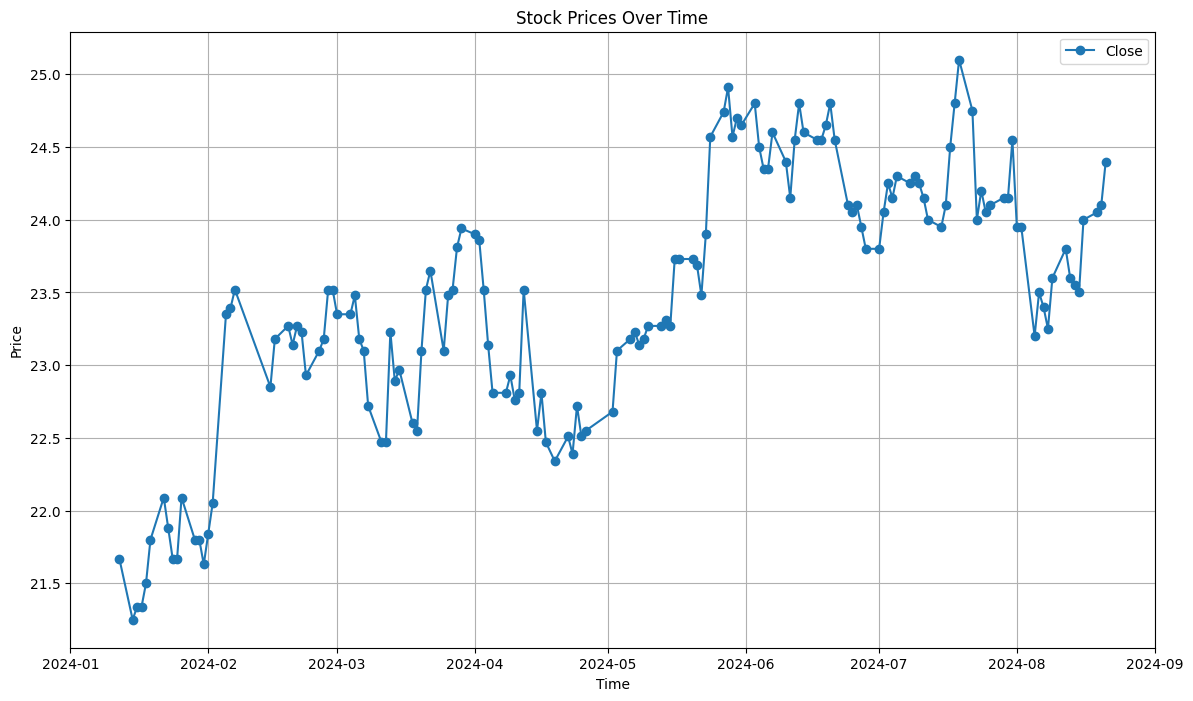

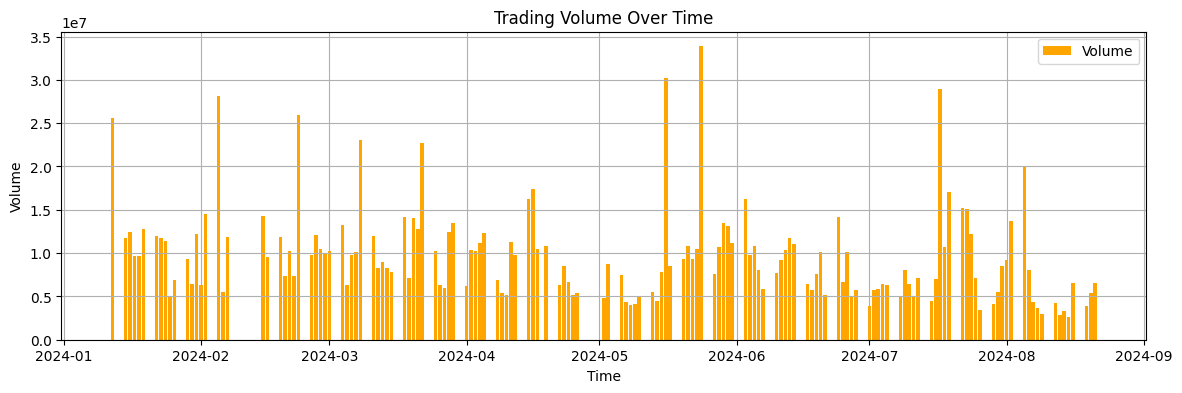

In [6]:
import pandas as pd
import matplotlib.pyplot as plt


df = stock.quote.history(start='2024-07-01', end='2024-08-21', interval='1D').iloc[100:]
df['time'] = pd.to_datetime(df['time'])

# Vẽ biểu đồ giá cổ phiếu
plt.figure(figsize=(14, 8))

# plt.plot(df['time'], df['open'], label='Open', marker='o')
# plt.plot(df['time'], df['high'], label='High', marker='o')
# plt.plot(df['time'], df['low'], label='Low', marker='o')
plt.plot(df['time'], df['close'], label='Close', marker='o')

# Thêm tiêu đề và nhãn
plt.title('Stock Prices Over Time')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()

# Hiển thị biểu đồ
plt.grid(True)
plt.show()

# Vẽ biểu đồ Volume
plt.figure(figsize=(14, 4))
plt.bar(df['time'], df['volume'], color='orange', label='Volume')

# Thêm tiêu đề và nhãn
plt.title('Trading Volume Over Time')
plt.xlabel('Time')
plt.ylabel('Volume')
plt.legend()

# Hiển thị biểu đồ
plt.grid(True)
plt.show()


In [7]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler_volume = MinMaxScaler()

def data_process(df):

    df['log_volume'] = np.log(df['volume'] + 1)
    df['proccesed_volume'] = min_max_scaler_volume.fit_transform(df[['log_volume']])

    for col in ['open', 'high', 'low', 'close']:
        df[f'proccesed_{col}'] = df[col].pct_change()

    return df.fillna(0)

In [8]:
import time
def get_data(group: list[str],
             source: str,
             start_date: str,
             end_date: str,
             interval: str):
    df_list = []
    for symbol in group:
        if len(df_list) >= 5:
          break
        try:
          stock = Vnstock().stock(symbol=symbol, source = source)
          df = data_process(stock.quote.history(start=start_date, end=end_date, interval=interval))
          df_list.append(df)
          print(f'tai thanh cong du lieu tu stock {symbol}')
          time.sleep(5)
        except:
          print('lỗi tải xuống dữ liệu')
    return df_list


In [9]:
df_list = get_data(group = HOSE_list, source = 'TCBS', start_date = '2022-01-01', end_date = '2024-08-25',interval =  '1D')

tai thanh cong du lieu tu stock AAA
tai thanh cong du lieu tu stock AAM
tai thanh cong du lieu tu stock AAT
tai thanh cong du lieu tu stock ABR
tai thanh cong du lieu tu stock ABS


In [ ]:
df_list[0]

#LSTM


In [ ]:
import pandas as pd

# Giả sử bạn đã có DataFrame của mình
# df = pd.read_csv('file.csv')  # Nếu dữ liệu của bạn được lưu trong file CSV

# Lựa chọn các cột cần thiết
stock_list = []
for df in df_list:
    columns = ['proccesed_open', 'proccesed_close', 'proccesed_low', 'proccesed_high', 'proccesed_volume']
    data_list = df_list[0][columns].values.tolist()
    stock_list.append(data_list)

In [ ]:
data_array = np.array(stock_list)

In [ ]:
data_array.shape

(396, 745, 5)

In [ ]:
import tensorflow as tf

def windowed_dataset(series, window_size, shift_size, batch_size, shuffle_buffer):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + shift_size, shift=shift_size, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + shift_size))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
window_size = 100
batch_size = 32
shuffle_buffer_size = 1000
shift_size = 10
number_feature = 5

In [ ]:
# Dùng dataset API để xử lý nhiều chuỗi cùng lúc
dataset = tf.data.Dataset.from_tensor_slices(data_array)
dataset = dataset.flat_map(lambda seq: windowed_dataset(seq, window_size=window_size, batch_size=batch_size, shift_size = shift_size, shuffle_buffer=shuffle_buffer_size))

In [ ]:
# for i, (x, y) in enumerate(dataset.take(5)):  # Lấy 5 batch đầu tiên
#     print(f"Batch {i+1}:")
#     print(f"x: {x.numpy()}")
#     print(f"y: {y.numpy()}")
#     print()

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Conv1D

# Định nghĩa mô hình LSTM
model = Sequential([
    Conv1D(filters=16, kernel_size=5, activation='relu', padding = 'same', input_shape=(None, number_feature)),
    Bidirectional(LSTM(16, return_sequences=True)),  # 16 units, input shape (window_size, 5)
    Dropout(0.2),  # Dropout layer để tránh overfitting
    Dense(8, activation='relu'),
    Dropout(0.2),  # Dropout layer để tránh overfitting
    Dense(5)  # Dense layer để dự đoán đầu ra có kích thước 5 (tương ứng với số lượng đặc trưng)
])

# Biên dịch mô hình
model.compile(optimizer='adam', loss=tf.keras.losses.Huber(), metrics=['mae'])


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, None, 16)            │             416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, None, 32)            │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, None, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, None, 8)             │             264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, None, 8)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, None, 5)             │              45 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,949 (19.33 KB)

 Trainable params: 4,949 (19.33 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(dataset, epochs=30, verbose=1)

Epoch 1/30
792/792 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - loss: 0.0062 - mae: 0.0666
Epoch 2/30


Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.


792/792 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - loss: 6.9966e-04 - mae: 0.0226
Epoch 3/30
792/792 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - loss: 4.5385e-04 - mae: 0.0186
Epoch 4/30
792/792 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - loss: 3.6011e-04 - mae: 0.0168
Epoch 5/30
792/792 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - loss: 3.4858e-04 - mae: 0.0164
Epoch 6/30
792/792 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - loss: 3.4313e-04 - mae: 0.0162
Epoch 7/30
792/792 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 3.3941e-04 - mae: 0.0161
Epoch 8/30
792/792 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - loss: 3.3847e-04 - mae: 0.0160
Epoch 9/30
792/792 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - loss: 3.3621e-04 - mae: 0.0159
Epoch 10/30
792/792 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - loss: 3.3420e-04 - mae: 0.0159
Epoch 11/30
792/792 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - loss: 3.3420e-04 - mae: 0.0158
Epoch 12/30
792/792 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - loss: 3.3315e-04 - mae: 0.0158
Epoch 13/30
792/792 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/s

In [ ]:
def model_forecast(model, series, window_size, shift_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=shift_size , drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds,verbose=0)
  return forecast

def predict_stock_price(model, stock_name, start_date, end_date, interval, number_day_predict, shift_size):
    stock = Vnstock().stock(symbol=stock_name, source='TCBS')
    df = data_process(stock.quote.history(start=start_date, end=end_date, interval=interval))
    columns = ['proccesed_open', 'proccesed_close', 'proccesed_low', 'proccesed_high', 'proccesed_volume']
    data_list = np.array(df[columns].values.tolist())
    predict_list = []
    for day in range(number_day_predict):
      forecast = model_forecast(model, data_list, window_size, shift_size = shift_size)
      print(forecast.shape)
      data_list = data_list[shift_size:, :]
      data_list = np.vstack([data_list, forecast[-1][shift_size * -1:]])
      predict_list = [arr.tolist() for arr in list(forecast[-1][shift_size * -1:])]

    df_new = pd.DataFrame(np.array(predict_list), columns = columns)
    df_new['time'] = pd.date_range(start=df['time'].iloc[-1] + pd.Timedelta(days=1), periods=len(df_new), freq='D')
    df_new['log_volume'] = min_max_scaler_volume.inverse_transform(df_new[['proccesed_volume']])
    df_new['volume'] = np.exp(df_new['log_volume']) - 1
    df_new['volume'] = df_new['volume'].round().astype(int)
    df_new['open'] = df['open'].iloc[-1] * (1 + df_new['proccesed_open'])
    df_new['high'] = df['high'].iloc[-1] * (1 + df_new['proccesed_high'])
    df_new['low'] = df['low'].iloc[-1] * (1 + df_new['proccesed_low'])
    df_new['close'] = df['close'].iloc[-1] * (1 + df_new['proccesed_close'])
    df_final = pd.concat([df, df_new], ignore_index=True)
    return df_final,  predict_list

In [ ]:
p = predict_stock_price(model = model, stock_name = 'TCD', start_date = '2023-01-01', end_date = '2024-07-01', interval = '1D', number_day_predict = 1, shift_size = 10)

(36, 100, 5)


Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.


In [ ]:
a,b = p

#LTSM cho 1 thuộc tính

In [10]:
stock_list = []
for df in df_list:
    columns = ['proccesed_close']
    data_list = df_list[0][columns].values.tolist()
    stock_list.append(data_list)

In [11]:
data_array = np.array(stock_list)

In [29]:
import tensorflow as tf

def windowed_dataset(series, window_size, shift_size, batch_size, shuffle_buffer):
    ds = tf.data.Dataset.from_tensor_slices(tf.expand_dims(series, axis=-1))
    ds = ds.window(window_size + shift_size, shift=shift_size, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + shift_size))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [30]:
window_size = 100
batch_size = 32
shuffle_buffer_size = 1000
shift_size = 10
number_feature = 1

In [36]:
# Dùng dataset API để xử lý nhiều chuỗi cùng lúc
dataset = tf.data.Dataset.from_tensor_slices(data_array)
dataset = dataset.flat_map(lambda seq: windowed_dataset(seq, window_size=window_size, batch_size=batch_size, shift_size = shift_size, shuffle_buffer=shuffle_buffer_size))

In [37]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Conv1D

# Định nghĩa mô hình LSTM
model = Sequential([
    Conv1D(filters=16, kernel_size=5, activation='relu', padding = 'same', input_shape=(None,number_feature)),
    Bidirectional(LSTM(16, return_sequences=True,)),  # 16 units, input shape (window_size, 5)
    Dropout(0.2),  # Dropout layer để tránh overfitting
    Dense(8, activation='relu'),
    Dropout(0.2),  # Dropout layer để tránh overfitting
    Dense(1)  # Dense layer để dự đoán đầu ra có kích thước 5 (tương ứng với số lượng đặc trưng)
])

# Biên dịch mô hình
model.compile(optimizer='adam', loss=tf.keras.losses.Huber(), metrics=['mae'])

In [39]:
model.fit(dataset, epochs=30, verbose=1)

Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 3.8798e-05 - mae: 0.0051
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 3.7339e-05 - mae: 0.0050
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 3.9199e-05 - mae: 0.0051
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - loss: 3.6522e-05 - mae: 0.0049
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 3.6702e-05 - mae: 0.0049
Epoch 6/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 3.7730e-05 - mae: 0.0050
Epoch 7/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 3.6627e-05 - mae: 0.0049
Epoch 8/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 3.7009e-05 - mae: 0.0050
Epoch 9/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 3.8033e-05 - mae: 0.0051
Epoch 10/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 3.6637e-05 - mae: 0.0049
Epoch 11/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 3.5900e-05 - mae: 0.0049
Epoch 12/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 3.6611e-05 - 

In [45]:
def model_forecast(model, series, window_size, shift_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=shift_size , drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds,verbose=0)
  return forecast

def predict_stock_price(model, stock_name, start_date, end_date, interval, number_predict_forward, shift_size):
    stock = Vnstock().stock(symbol=stock_name, source='TCBS')
    df = data_process(stock.quote.history(start=start_date, end=end_date, interval=interval))
    columns = ['proccesed_close']
    data_list = np.array(df[columns].values.tolist())
    predict_list = []
    for day in range(number_predict_forward):
      forecast = model_forecast(model, data_list, window_size, shift_size = shift_size)
      data_list = data_list[shift_size:, :]
      data_list = np.vstack([data_list, forecast[-1][shift_size * -1:]])
      predict_list = predict_list + [arr.tolist() for arr in list(forecast[-1][shift_size * -1:])]

    df_new = pd.DataFrame(np.array(predict_list), columns = columns)
    df_new['time'] = pd.date_range(start=df['time'].iloc[-1] + pd.Timedelta(days=1), periods=len(df_new), freq='D')
    df_new['close'] = df['close'].iloc[-1] * (1 + df_new['proccesed_close'])
    df_final = pd.concat([df, df_new], ignore_index=True)
    return df_final,  predict_list

In [46]:
p = predict_stock_price(model = model, stock_name = 'TCD', start_date = '2023-01-01', end_date = '2024-07-01', interval = '1D', number_predict_forward = 1, shift_size = 10)

Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.


In [47]:
a, b = p

In [48]:
a


,time,open,high,low,close,volume,log_volume,proccesed_volume,proccesed_open,proccesed_high,proccesed_low,proccesed_close
0,2023-06-29,7.59,7.72,7.34,7.340000,4371861.0,15.290700,0.751270,0.000000,0.000000,0.000000,0.000000
1,2023-06-30,7.41,7.55,7.34,7.480000,1732031.0,14.364806,0.488369,-0.023715,-0.022021,0.000000,0.019074
2,2023-07-03,7.49,7.71,7.49,7.680000,1888131.0,14.451099,0.512871,0.010796,0.021192,0.020436,0.026738
3,2023-07-04,7.78,7.80,7.58,7.640000,2330687.0,14.661674,0.572663,0.038718,0.011673,0.012016,-0.005208
4,2023-07-05,7.67,7.76,7.58,7.640000,1991500.0,14.504399,0.528006,-0.014139,-0.005128,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
461,2024-07-07,NaN,NaN,NaN,6.084084,NaN,NaN,NaN,NaN,NaN,NaN,0.000672
462,2024-07-08,NaN,NaN,NaN,6.041908,NaN,NaN,NaN,NaN,NaN,NaN,-0.006265
463,2024-07-09,NaN,NaN,NaN,6.014189,NaN,NaN,NaN,NaN,NaN,NaN,-0.010824
464,2024-07-10,NaN,NaN,NaN,6.063235,NaN,NaN,NaN,NaN,NaN,NaN,-0.002757


#Plot

In [ ]:
def plot_trend(df, number_day):
  df_last_n_days = df.tail(number_day)

  # Vẽ biểu đồ giá 'close' cho n ngày cuối
  plt.figure(figsize=(10, 6))
  plt.plot(df_last_n_days['time'], df_last_n_days['close'], marker='o')
  plt.title(f'Giá Close của {number_day} ngày gần nhất')
  plt.xlabel('Time')
  plt.ylabel('Close Price')
  plt.grid(True)
  plt.xticks(rotation=45)
  plt.show()

In [ ]:
stock = Vnstock().stock(symbol='TCD', source='TCBS')
df_test = data_process(stock.quote.history(start = '2023-01-01', end = '2024-07-12', interval = '1D'))